# Compare the GM-SEUS products (arrays & individual panels) to the existing collected dataproducts (USPVDB, CCPV, SAM, OSM, and OSM/CCPV panel shapes )  

For GMSEUS "Big Panel" paper with Jacob Stid (stidjaco@msu.edu)  
Work in this notebook from Jeremy Rapp (rappjer1@gmail.com) 

In [1]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Polygon comparison

   subArrID  arrayID nativeID Source  pnlNum        area       mount  \
0       0.0      0.0        1  CCVPV    24.0  155.792036  fixed_axis   
1       1.0      1.0       10  CCVPV     4.0  344.579843  fixed_axis   
2       2.0      2.0       10    OSM    55.0   18.823460  fixed_axis   
3       4.0      2.0       10    OSM    28.0   23.603587  fixed_axis   
4       7.0      2.0       10    OSM    27.0   20.615768  fixed_axis   

      azimuth  lengthRati  shortEdge   longEdge  QAQC   perimeter  PmArRatio  \
0  193.765348    9.708524   4.221357  40.983141     0   88.407122   0.039443   
1  193.309299   17.963528   4.532977  81.428268     0  170.042028   0.105165   
2  173.955739   51.920637   0.602117  31.262310     0   63.728790   0.042146   
3  533.957987   65.106336   0.602109  39.201104     0   79.606434   0.084995   
4  173.957868   56.864729   0.602112  34.238907     0   69.682020   0.087323   

   compactnes  areaRatio  numPanels      pnlArea     arrayArea  \
0    0.250484   0.30

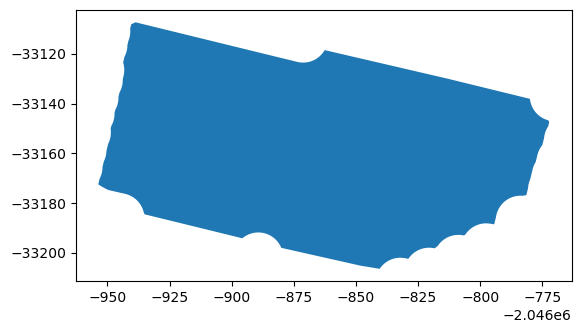

In [3]:
# load the panel polygons for comparison
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')

# get only gmseus arrays where Source == 'gmseus'
# gmseus_arrays = gmseus_arrays[gmseus_arrays['Source'] == 'gmseus']

# print the first few rows of the data
print(gmseus_arrays.head())
print(gmseus_arrays.shape)
print('GMSEUS arrays attributes')
print(gmseus_arrays.area.describe())

# get only gmseus arrays where Source == 'gmseus'

# create a subset of the data 10 rows long
gmseus_arrays_subset = gmseus_arrays.head(1)

# plot the subset of the data
gmseus_arrays_subset.plot()
plt.show()


In [4]:
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
#print(uspvdb_arrays.head())


# print the first few rows of the data
print(uspvdb_arrays.head())
print(uspvdb_arrays.shape)
print('USPVDB arrays attributes')
print(uspvdb_arrays.area.describe())


# Explode the geometries
# exploded_uspvdb = explode_geometries(uspvdb_arrays)

# # Print the first few rows of the exploded data
# print(exploded_uspvdb.head())

# # Get the first few rows of the exploded data
# exploded_uspvdb_subset = exploded_uspvdb.head(1)

# # Plot the exploded data
# exploded_uspvdb_subset.plot()
# plt.show()

  nativeID  instYr  cap_mw       area    modType AVtype  azimuth        mount  \
0   401476    2016   100.2  1735134.0       c-si   None    180.0  single_axis   
1   401865    2017    12.7   187820.0  thin-film   None    180.0  single_axis   
2   401866    2017     9.7    39717.0  thin-film   None    180.0         None   
3   402674    2017    12.5   194595.0       c-si   None    180.0  single_axis   
4   401807    2017   116.9  1881927.0       c-si   None    180.0  single_axis   

   Source                                           geometry  
0  USPVDB  MULTIPOLYGON Z (((738788.612 -265689.712 0, 73...  
1  USPVDB  MULTIPOLYGON Z (((971961.129 -636561.614 0, 97...  
2  USPVDB  MULTIPOLYGON Z (((925171.423 -384591.972 0, 92...  
3  USPVDB  MULTIPOLYGON Z (((853104.416 -280973.172 0, 85...  
4  USPVDB  MULTIPOLYGON Z (((985679.478 -461141.159 0, 98...  
(4185, 10)
USPVDB arrays attributes
count    4.185000e+03
mean     3.836397e+05
std      1.004317e+06
min      1.560708e+03
25%      3.

In [38]:
import geopandas as gpd

# Load the GMSEUS arrays and fix geometries
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')
gmseus_arrays['geometry'] = gmseus_arrays.buffer(0)

# check if any gmseus arrays overlap
gmseus_self_overlap = gmseus_arrays.geometry.apply(lambda g: not g.is_valid)

if gmseus_self_overlap.any():
    print("Some GMSEUS geometries self-overlap or are invalid.")
    invalid_geometries = gmseus_arrays[gmseus_self_overlap]
    print(f"Number of invalid geometries: {len(invalid_geometries)}")
else:
    print("All GMSEUS geometries are valid and do not self-overlap.")

# Load USPVDB arrays and fix geometries
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
uspvdb_arrays['geometry'] = uspvdb_arrays.buffer(0)

# Ensure CRS consistency
if gmseus_arrays.crs != uspvdb_arrays.crs:
    uspvdb_arrays = uspvdb_arrays.to_crs(gmseus_arrays.crs)

# Add explicit IDs to preserve original indices
gmseus_arrays = gmseus_arrays.reset_index().rename(columns={'index': 'gmseus_id'})
uspvdb_arrays = uspvdb_arrays.reset_index().rename(columns={'index': 'uspvdb_id'})

# Perform spatial join to identify intersections
intersections = gpd.sjoin(uspvdb_arrays, gmseus_arrays, how="inner", predicate="intersects")

# Group USPVDB geometries by GMSEUS ID and union them
unioned_uspvdb = (
    intersections.groupby('gmseus_id')['geometry']
    .apply(lambda g: g.unary_union)  # Union the full original USPVDB geometries
    .reset_index()
)

# Merge unioned geometries back into the original USPVDB dataset
updated_uspvdb = uspvdb_arrays.copy()
updated_uspvdb = updated_uspvdb.merge(
    unioned_uspvdb, how='left', left_on='uspvdb_id', right_on='gmseus_id', suffixes=('', '_unioned')
)

# Replace geometry in USPVDB with unioned geometry where applicable
updated_uspvdb['geometry'] = updated_uspvdb['geometry_unioned'].combine_first(updated_uspvdb['geometry'])
updated_uspvdb = updated_uspvdb.drop(columns=['geometry_unioned', 'gmseus_id'])



All GMSEUS geometries are valid and do not self-overlap.


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\2227900572.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union)  # Union the full original USPVDB geometries


In [58]:

# Step 1: Load and Fix Geometries
gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')

# Ensure valid geometries
gmseus_arrays['geometry'] = gmseus_arrays.buffer(0)
uspvdb_arrays['geometry'] = uspvdb_arrays.buffer(0)

# Ensure CRS consistency
if gmseus_arrays.crs != uspvdb_arrays.crs:
    uspvdb_arrays = uspvdb_arrays.to_crs(gmseus_arrays.crs)

# Add explicit IDs
gmseus_arrays = gmseus_arrays.reset_index().rename(columns={'index': 'gmseus_id'})
uspvdb_arrays = uspvdb_arrays.reset_index().rename(columns={'index': 'uspvdb_id'})

# Step 2: Simplify USPVDB Geometries
intersections = gpd.sjoin(uspvdb_arrays, gmseus_arrays, how="inner", predicate="intersects")
simplified_uspvdb = (
    intersections.groupby('uspvdb_id')['geometry']
    .apply(lambda g: g.unary_union)  # Use union_all() if unary_union is deprecated
    .reset_index()
)
simplified_uspvdb_gdf = gpd.GeoDataFrame(simplified_uspvdb, geometry='geometry', crs=uspvdb_arrays.crs)

# Step 3: Simplify GMSEUS Geometries Based on Simplified USPVDB
intersections = gpd.sjoin(gmseus_arrays, simplified_uspvdb_gdf, how="inner", predicate="intersects")
simplified_gmseus = (
    intersections.groupby('uspvdb_id')['geometry']
    .apply(lambda g: g.unary_union)  # Use union_all
    .reset_index()
)

# Convert to GeoDataFrame and ensure CRS is preserved
simplified_gmseus_gdf = gpd.GeoDataFrame(simplified_gmseus, geometry='geometry', crs=gmseus_arrays.crs)

# Manually add a gmseus_id for tracking (since original IDs were lost during unioning)
simplified_gmseus_gdf = simplified_gmseus_gdf.reset_index().rename(columns={'index': 'gmseus_id'})

# Step 4: Ensure One-to-One Mapping
# Perform a spatial join to link GMSEUS and USPVDB geometries
final_intersections = gpd.sjoin(simplified_gmseus_gdf, simplified_uspvdb_gdf, how="inner", predicate="intersects")

# Print column names to verify
print(f"Columns in final_intersections: {final_intersections.columns}")

# Group by the correct column for USPVDB IDs
# Use the correct column name based on the printed output (e.g., 'uspvdb_id_right')
final_intersections = (
    final_intersections.groupby('uspvdb_id_right')['geometry']  # Adjust column name here
    .apply(lambda g: g.unary_union)  # Use union_all() if unary_union is deprecated
    .reset_index()
)

# Rename for consistency
final_intersections = final_intersections.rename(columns={'uspvdb_id_right': 'uspvdb_id'})

# Add area calculations
simplified_gmseus_gdf['area_a'] = simplified_gmseus_gdf.geometry.area
simplified_uspvdb_gdf['area_b'] = simplified_uspvdb_gdf.geometry.area
final_intersections['intersection_area'] = final_intersections.geometry.area

# Merge area attributes
final_intersections = final_intersections.merge(
    simplified_gmseus_gdf[['uspvdb_id', 'area_a']], on='uspvdb_id', how='left'
)
final_intersections = final_intersections.merge(
    simplified_uspvdb_gdf[['uspvdb_id', 'area_b']], on='uspvdb_id', how='left'
)

# Step 5: Calculate Metrics (Jaccard and GOF)
final_intersections['union_area'] = (
    final_intersections['area_a'] + final_intersections['area_b'] - final_intersections['intersection_area']
)
final_intersections['jaccard_index'] = final_intersections['intersection_area'] / final_intersections['union_area']
final_intersections['insideness'] = final_intersections['intersection_area'] / final_intersections['area_b']
final_intersections['weight'] = final_intersections['intersection_area'] / final_intersections['area_a']
final_intersections['gof'] = final_intersections['insideness'] * final_intersections['weight']

# Summarize Metrics
overall_gof = final_intersections['gof'].mean()
average_jaccard = final_intersections['jaccard_index'].mean()

# Save results
simplified_uspvdb_gdf.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_simplified_union.shp')
simplified_gmseus_gdf.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\gmseus_simplified_union.shp')
final_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\final_intersections_with_metrics.shp')

# Print summary
print(f"Overall GOF: {overall_gof}")
print(f"Average Jaccard Index: {average_jaccard}")

# Return Data for Plotting
final_results = {
    "intersections_gdf": final_intersections,
    "overall_gof": overall_gof,
    "average_jaccard": average_jaccard,
    "simplified_uspvdb_gdf": simplified_uspvdb_gdf,
    "simplified_gmseus_gdf": simplified_gmseus_gdf,
}


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\2437181023.py:21: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union)  # Use union_all() if unary_union is deprecated
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\2437181023.py:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union)  # Use union_all


Columns in final_intersections: Index(['gmseus_id', 'uspvdb_id_left', 'geometry', 'index_right',
       'uspvdb_id_right'],
      dtype='object')


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\2437181023.py:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda g: g.unary_union)  # Use union_all() if unary_union is deprecated
C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\2437181023.py:87: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\final_intersections_with_metrics.shp')


Overall GOF: 0.7817943559853147
Average Jaccard Index: 0.7958318929533045


g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'intersection_area' to 'intersecti'
  ogr_write(
g:\Code\Envs\BigPanel\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'jaccard_index' to 'jaccard_in'
  ogr_write(


In [39]:
# Average size of exploded geometries
# print(gmseus_arrays.shape)
# print('GMSEUS arrays attributes')
# print(gmseus_arrays.area.describe())
# print(' ')
print(uspvdb_arrays.shape)
print('USPVDB arrays attributes')
print(uspvdb_arrays.area.describe())
print(' ')
print(updated_uspvdb.shape)
print('updated USPVDB arrays attributes')
print(updated_uspvdb.area.describe())

(4185, 11)
USPVDB arrays attributes
count    4.185000e+03
mean     3.836397e+05
std      1.004317e+06
min      1.560708e+03
25%      3.625148e+04
50%      7.058871e+04
75%      1.822239e+05
max      1.365787e+07
dtype: float64
 
(4185, 11)
updated USPVDB arrays attributes
count    4.185000e+03
mean     5.475752e+05
std      1.156108e+06
min      1.560708e+03
25%      4.306443e+04
50%      9.181577e+04
75%      4.295669e+05
max      1.248087e+07
dtype: float64


In [28]:
# Average size of exploded geometries
print(gmseus_arrays.shape)
print('GMSEUS arrays attributes')
print(gmseus_arrays.area.describe())
print(' ')
print(updated_uspvdb.shape)
print('USPVDB arrays attributes')
print(updated_uspvdb.area.describe())

(10355, 21)
GMSEUS arrays attributes
count    1.035500e+04
mean     8.374514e+04
std      2.421731e+05
min      1.731794e+02
25%      7.454260e+03
50%      2.058750e+04
75%      5.778065e+04
max      4.980026e+06
dtype: float64
 
(4185, 11)
USPVDB arrays attributes
count    4.185000e+03
mean     2.721534e+05
std      7.570474e+05
min      6.152066e+02
25%      2.548914e+04
50%      5.073517e+04
75%      1.441732e+05
max      1.248087e+07
dtype: float64


In [ ]:
# # Print information about the exploded data
# print(gmseus_arrays.shape)
# print(uspvdb_arrays.shape)
# print(exploded_gmseus.shape)
# print(exploded_uspvdb.shape)

# # Average size of exploded geometries
# print(exploded_gmseus.shape)
# print('GMSEUS exploded arrays attributes')
# print(exploded_gmseus.area.describe())
# print(' ')
# print(exploded_uspvdb.shape)
# print('USPVDB exploded arrays attributes')
# print(exploded_uspvdb.area.describe())

In [40]:
def calculate_gof_and_jaccard_vectorized(map1, map2):
    """
    Calculate Goodness-of-Fit (GOF) and Jaccard Index for intersections between two maps using vectorized operations.
    
    Parameters:
        map1 (GeoDataFrame): First map with polygons to be compared.
        map2 (GeoDataFrame): Second map with polygons serving as the reference.
        
    Returns:
        intersections_gdf (GeoDataFrame): GeoDataFrame with intersections, Jaccard, and GOF scores.
        overall_gof (float): Overall GOF score for map1.
        average_jaccard (float): Average Jaccard Index for all intersections.
    """
    # Explode geometries for both maps
    # map1 = map1.explode(index_parts=True).reset_index(drop=True)
    # map2 = map2.explode(index_parts=True).reset_index(drop=True)

    # Ensure CRS match
    if map1.crs != map2.crs:
        map2 = map2.to_crs(map1.crs)
    
    # Add an explicit ID column to keep track of original indices
    map1['id_a'] = map1.index
    map2['id_b'] = map2.index

    # Perform spatial intersection to get intersected geometries
    intersections = gpd.overlay(map1, map2, how="intersection")

    # Add areas for map1, map2, and intersections
    map1['area_a'] = map1.geometry.area
    map2['area_b'] = map2.geometry.area
    intersections['intersection_area'] = intersections.geometry.area

    # Merge area attributes using explicit IDs
    intersections = intersections.merge(
        map1[['id_a', 'area_a']],
        on='id_a',
        how='left'
    )
    intersections = intersections.merge(
        map2[['id_b', 'area_b']],
        on='id_b',
        how='left'
    )

    # Calculate Jaccard Index
    intersections['union_area'] = intersections['area_a'] + intersections['area_b'] - intersections['intersection_area']
    intersections['jaccard_index'] = intersections['intersection_area'] / intersections['union_area']

    # Calculate GOF
    intersections['insideness'] = intersections['intersection_area'] / intersections['area_b']
    intersections['weight'] = intersections['intersection_area'] / intersections['area_a']
    intersections['gof'] = intersections['insideness'] * intersections['weight']
    
    # Calculate overall metrics
    overall_gof = intersections.groupby('id_a')['gof'].sum().mean()
    average_jaccard = intersections['jaccard_index'].mean()

    return intersections, overall_gof, average_jaccard


# Example usage
map1 = gmseus_arrays
map1['geometry'] = map1.buffer(0)
print(map1.is_valid.all())

map2 = updated_uspvdb
map2['geometry'] = map2.buffer(0)
print(map2.is_valid.all())  # Should now return True

# Calculate GOF and Jaccard
intersections_gdf, overall_gof, average_jaccard = calculate_gof_and_jaccard_vectorized(map1, map2)


True
True


In [27]:
def count_intersections_and_list_polygons(jaccard_df):
    # Group by id_a to analyze intersections for each polygon in dataset A
    grouped_by_a = jaccard_df.groupby('id_a').agg(
        num_intersections=('id_b', 'count'),  # Count the number of intersections
        unique_polygons=('id_b', lambda x: list(x.unique()))  # List unique IDs of polygons
    ).reset_index()

    # Group by id_b to analyze intersections for each polygon in dataset B
    grouped_by_b = jaccard_df.groupby('id_b').agg(
        num_intersections=('id_a', 'count'),
        unique_polygons=('id_a', lambda x: list(x.unique()))
    ).reset_index()

    return grouped_by_a, grouped_by_b

# Example usage
grouped_by_a, grouped_by_b = count_intersections_and_list_polygons(intersections_gdf)

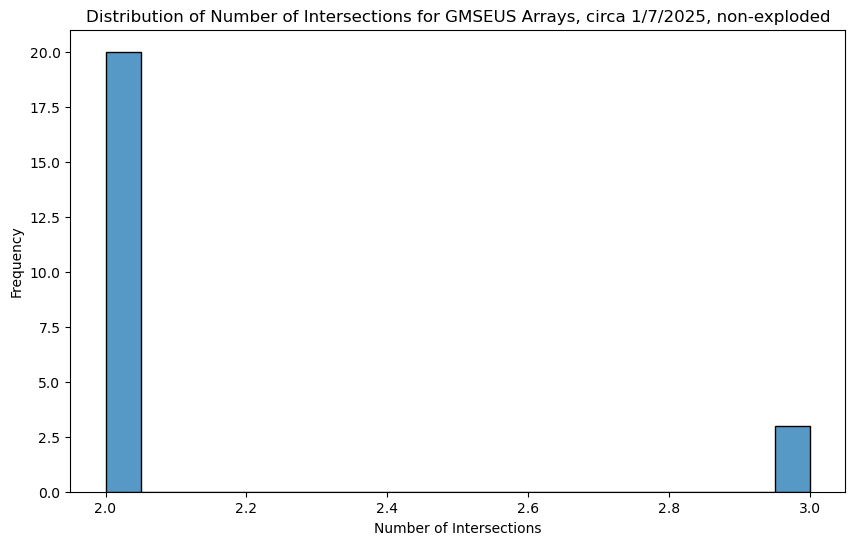

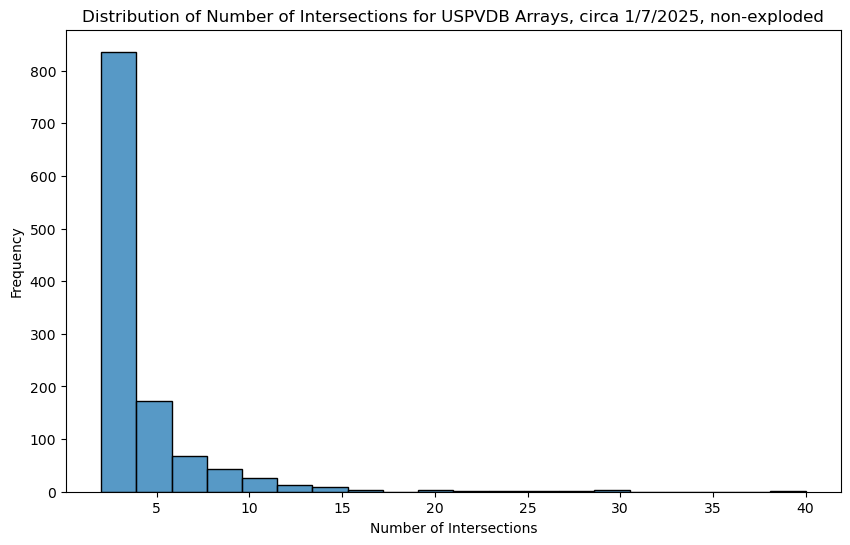

In [29]:
# only keep the polygons that have more than 1 intersection
grouped_by_a_filtered = grouped_by_a[grouped_by_a['num_intersections'] > 1]
grouped_by_b_filtered = grouped_by_b[grouped_by_b['num_intersections'] > 1]

# Plot the distribution of the number of intersections for each polygon in dataset A
plt.figure(figsize=(10, 6))
sns.histplot(grouped_by_a_filtered['num_intersections'], bins=20, kde=False)
plt.xlabel('Number of Intersections')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Intersections for GMSEUS Arrays, circa 1/7/2025, non-exploded')
plt.show()

# Plot the distribution of the number of intersections for each polygon in dataset B
plt.figure(figsize=(10, 6))
sns.histplot(grouped_by_b_filtered['num_intersections'], bins=20, kde=False)
plt.xlabel('Number of Intersections')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Intersections for USPVDB Arrays, circa 1/7/2025, non-exploded')
plt.show()

In [ ]:
print(map1.crs)
print(map2.crs)

print(map1.is_valid.all())
print(map2.is_valid.all())

print(map1.total_bounds)  # [minx, miny, maxx, maxy]
print(map2.total_bounds)

Overall GOF: 0.9375612144112536
Average Jaccard Index: 0.7220077190531419


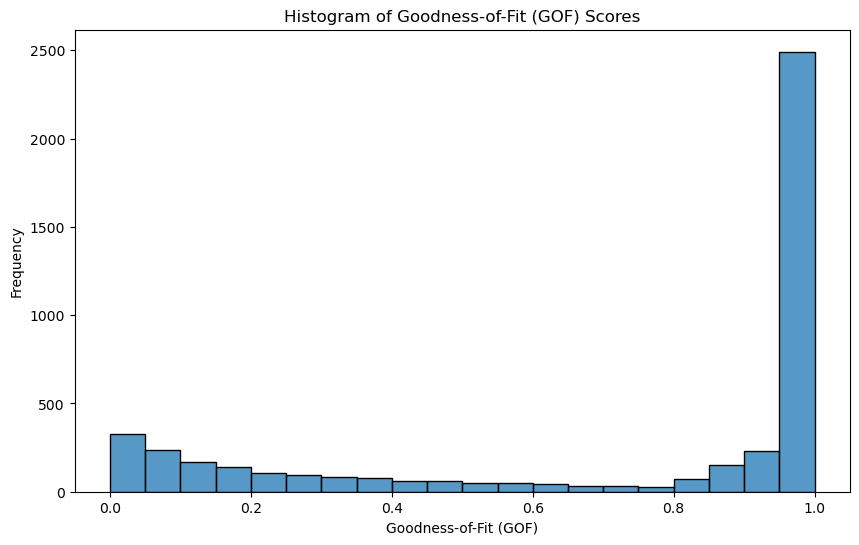

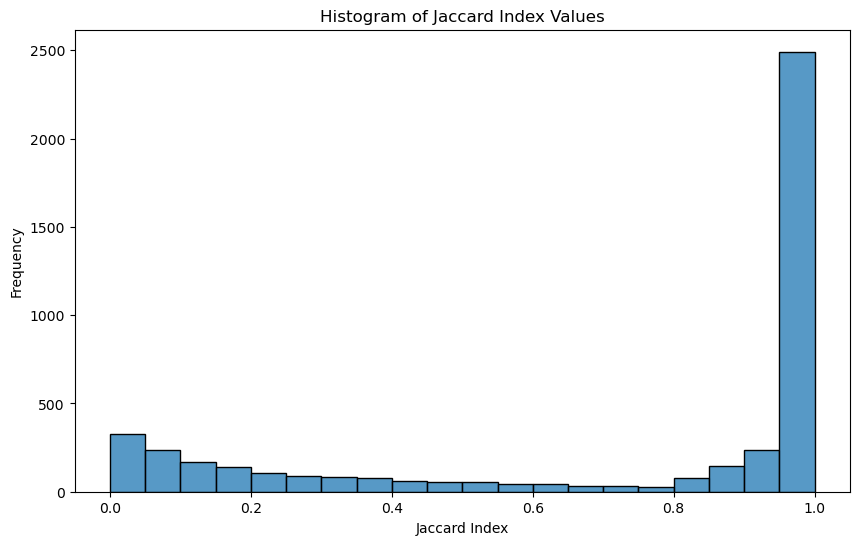

In [16]:
import seaborn as sns

# Print overall GOF and average Jaccard Index
print("Overall GOF:", overall_gof)
print("Average Jaccard Index:", average_jaccard)

# Plot the histogram of GOF scores
plt.figure(figsize=(10, 6))
sns.histplot(intersections_gdf['gof'], bins=20, kde=False)
plt.xlabel('Goodness-of-Fit (GOF)')
plt.ylabel('Frequency')
plt.title('Histogram of Goodness-of-Fit (GOF) Scores')
plt.show()

# Plot the histogram of Jaccard Index values
plt.figure(figsize=(10, 6))
sns.histplot(intersections_gdf['jaccard_index'], bins=20, kde=False)
plt.xlabel('Jaccard Index')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Index Values')
plt.show()

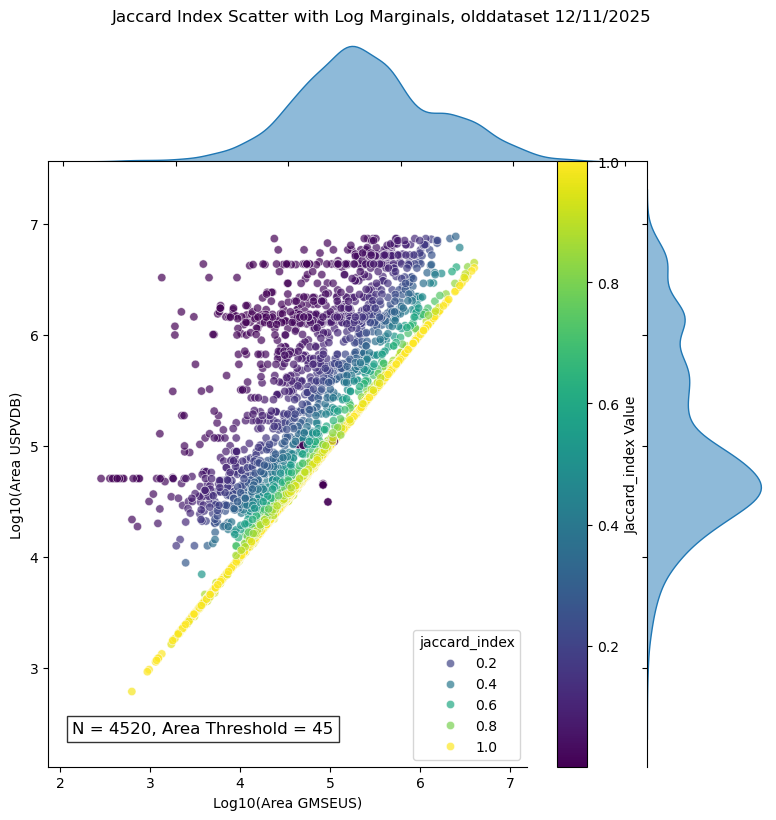

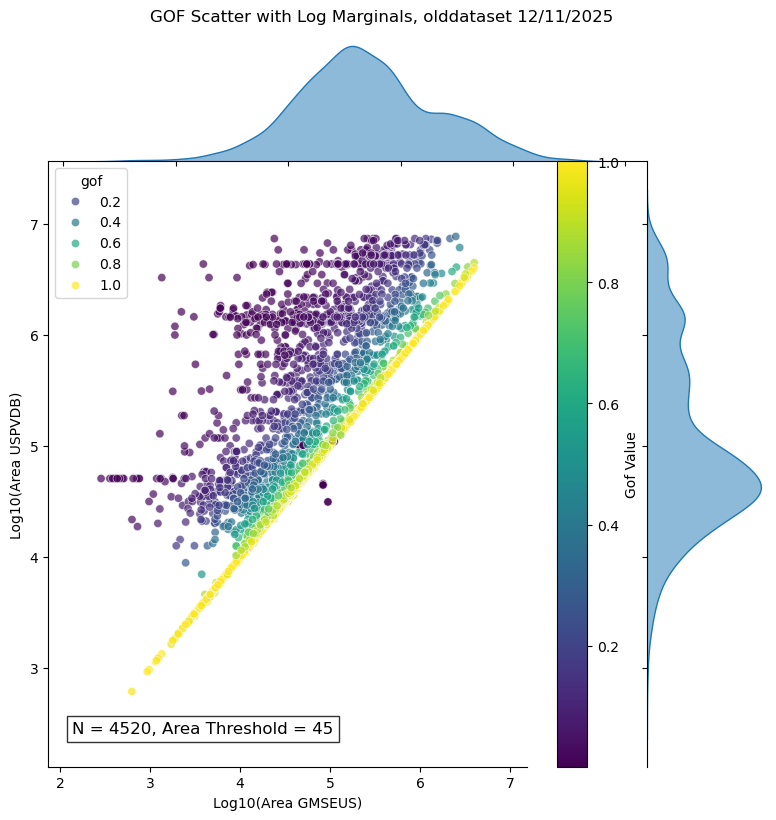

In [17]:


def scatter_with_log_marginals(intersections_gdf, metric, title="Log-Transformed Scatter Plot with Marginal Distributions", area_threshold = 45):
    """
    Scatter plot with log-transformed marginal distributions for areas and color-coded by a given metric.
    
    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing intersection data with areas and metrics.
        metric (str): The metric to visualize on the scatter plot ("jaccard_index" or "gof").
        title (str): Title for the plot.
    """
    if metric not in intersections_gdf.columns:
        raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")
    # filter out small areas
    intersections_gdf = intersections_gdf[(intersections_gdf['area_a'] > area_threshold) & (intersections_gdf['area_b'] > area_threshold)]

    # Apply log transformation to the area columns
    intersections_gdf['log_area_a'] = np.log10(intersections_gdf['area_a'])
    intersections_gdf['log_area_b'] = np.log10(intersections_gdf['area_b'])
    
    # Set up the grid
    g = sns.JointGrid(data=intersections_gdf, x="log_area_a", y="log_area_b", space=0, height=8)
    
    # Scatter plot in the center
    g.plot_joint(
        sns.scatterplot,
        hue=intersections_gdf[metric],
        palette='viridis',
        alpha=0.7
    )
    
    # KDE plots on the margins
    g.plot_marginals(sns.kdeplot, fill=True, alpha=0.5)
    
    # Customize color bar for the selected metric
    norm = plt.Normalize(intersections_gdf[metric].min(), intersections_gdf[metric].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = g.fig.colorbar(sm, ax=g.ax_joint, orientation="vertical", label=f"{metric.capitalize()} Value")
    
    # Set labels and title
    g.set_axis_labels("Log10(Area GMSEUS)", "Log10(Area USPVDB)")
    g.fig.suptitle(title, y=1.02)
    
    # Add a count of the number of points in the lower-left of the plot
    g.ax_joint.text(
        0.05, 0.05, f'N = {intersections_gdf.shape[0]}, Area Threshold = {area_threshold}',
        horizontalalignment='left', verticalalignment='bottom',
        transform=g.ax_joint.transAxes,
        fontsize=12, bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.show()

# Example usage:
# Scatter plot with Jaccard Index
scatter_with_log_marginals(intersections_gdf, metric="jaccard_index", title="Jaccard Index Scatter with Log Marginals, olddataset 12/11/2025")

# Scatter plot with GOF
scatter_with_log_marginals(intersections_gdf, metric="gof", title="GOF Scatter with Log Marginals, olddataset 12/11/2025")


In [18]:
# Boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(map1.crs)


def plot_intersections_with_metric(intersections, boundary_data, metric, map_label, metric_value):
    """
    Plot intersection points with a specified metric (Jaccard or GOF) as a color scale,
    overlaid on a boundary map using x and y coordinates for point locations.
    
    Parameters:
        intersections (GeoDataFrame): GeoDataFrame of intersections with calculated metrics.
        boundary_data (GeoDataFrame): GeoDataFrame representing the boundary (e.g., lower 48 states).
        metric (str): The metric to visualize ("jaccard_index" or "gof").
        map_label (str): Label for the map to use in titles and annotations.
    """
    # Ensure CRS match between intersections and boundary_data
    if intersections.crs != boundary_data.crs:
        boundary_data = boundary_data.to_crs(intersections.crs)

    # Check if the provided metric exists in the intersections GeoDataFrame
    if metric not in intersections.columns:
        raise ValueError(f"Metric '{metric}' not found in the intersections GeoDataFrame.")

    # Extract x and y coordinates for intersections
    intersections['x'] = intersections.geometry.centroid.x
    intersections['y'] = intersections.geometry.centroid.y

    # Create a plot
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot the boundary
    boundary_data.plot(ax=ax, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
    
    # Plot the intersection points with the metric as the color
    scatter = ax.scatter(
        intersections['x'], intersections['y'],
        c=intersections[metric],
        cmap='viridis',
        s=10,
        alpha=0.8,
        label="Intersections"
    )
    
    # Add a colorbar for the metric
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')
    cbar.set_label(f"{metric.capitalize()} Value")

    # Title and labels
    ax.set_title(f"{map_label} Intersections Colored by {metric.capitalize()}")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

        # Add a count of intersections as a text label
    intersection_count = len(intersections)
    ax.text(
        0.02, 0.98, f"Number of Intersections: {intersection_count}, {metric.capitalize()} Value: {metric_value}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    plt.grid(False)
    plt.legend()

    plt.show()

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\848147071.py:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


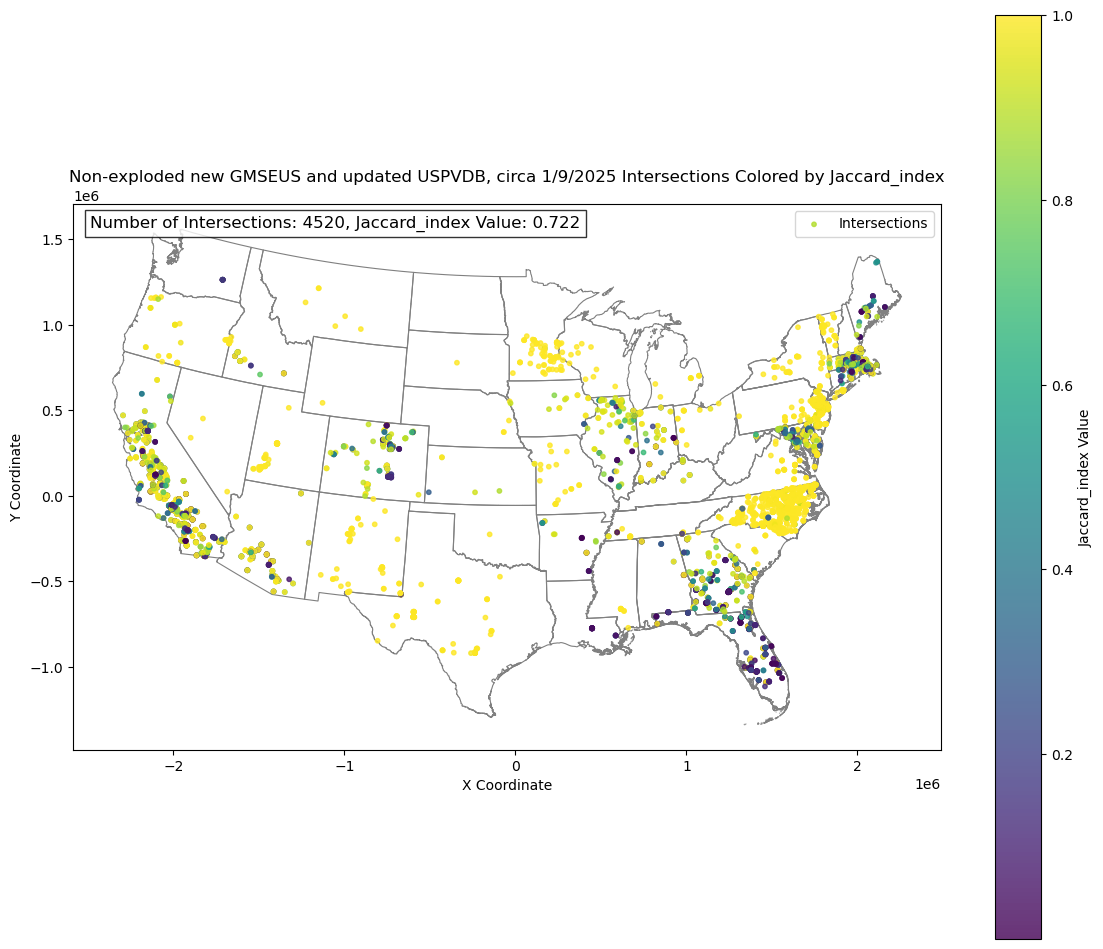

C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\848147071.py:64: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


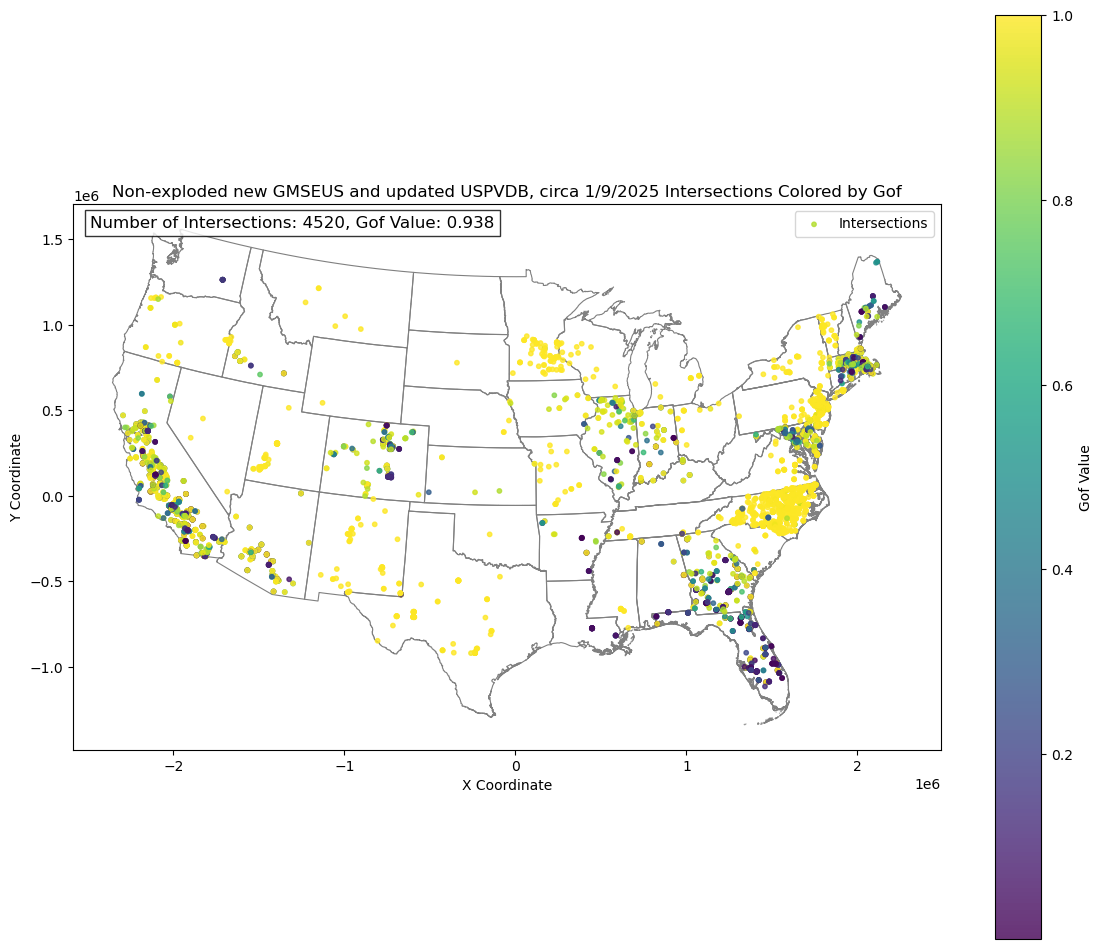

In [19]:
# set a float to 3 decimal places
overall_gof_rounded = round(overall_gof, 3)
average_jaccard_rounded = round(average_jaccard, 3)

# plot these plots as a subplot

# Plot intersections colored by Jaccard Index
plot_intersections_with_metric(intersections_gdf, us_boundary, "jaccard_index", "Non-exploded new GMSEUS and updated USPVDB, circa 1/9/2025", average_jaccard_rounded)

# Plot intersections colored by GOF
plot_intersections_with_metric(intersections_gdf, us_boundary, "gof", "Non-exploded new GMSEUS and updated USPVDB, circa 1/9/2025", overall_gof_rounded)

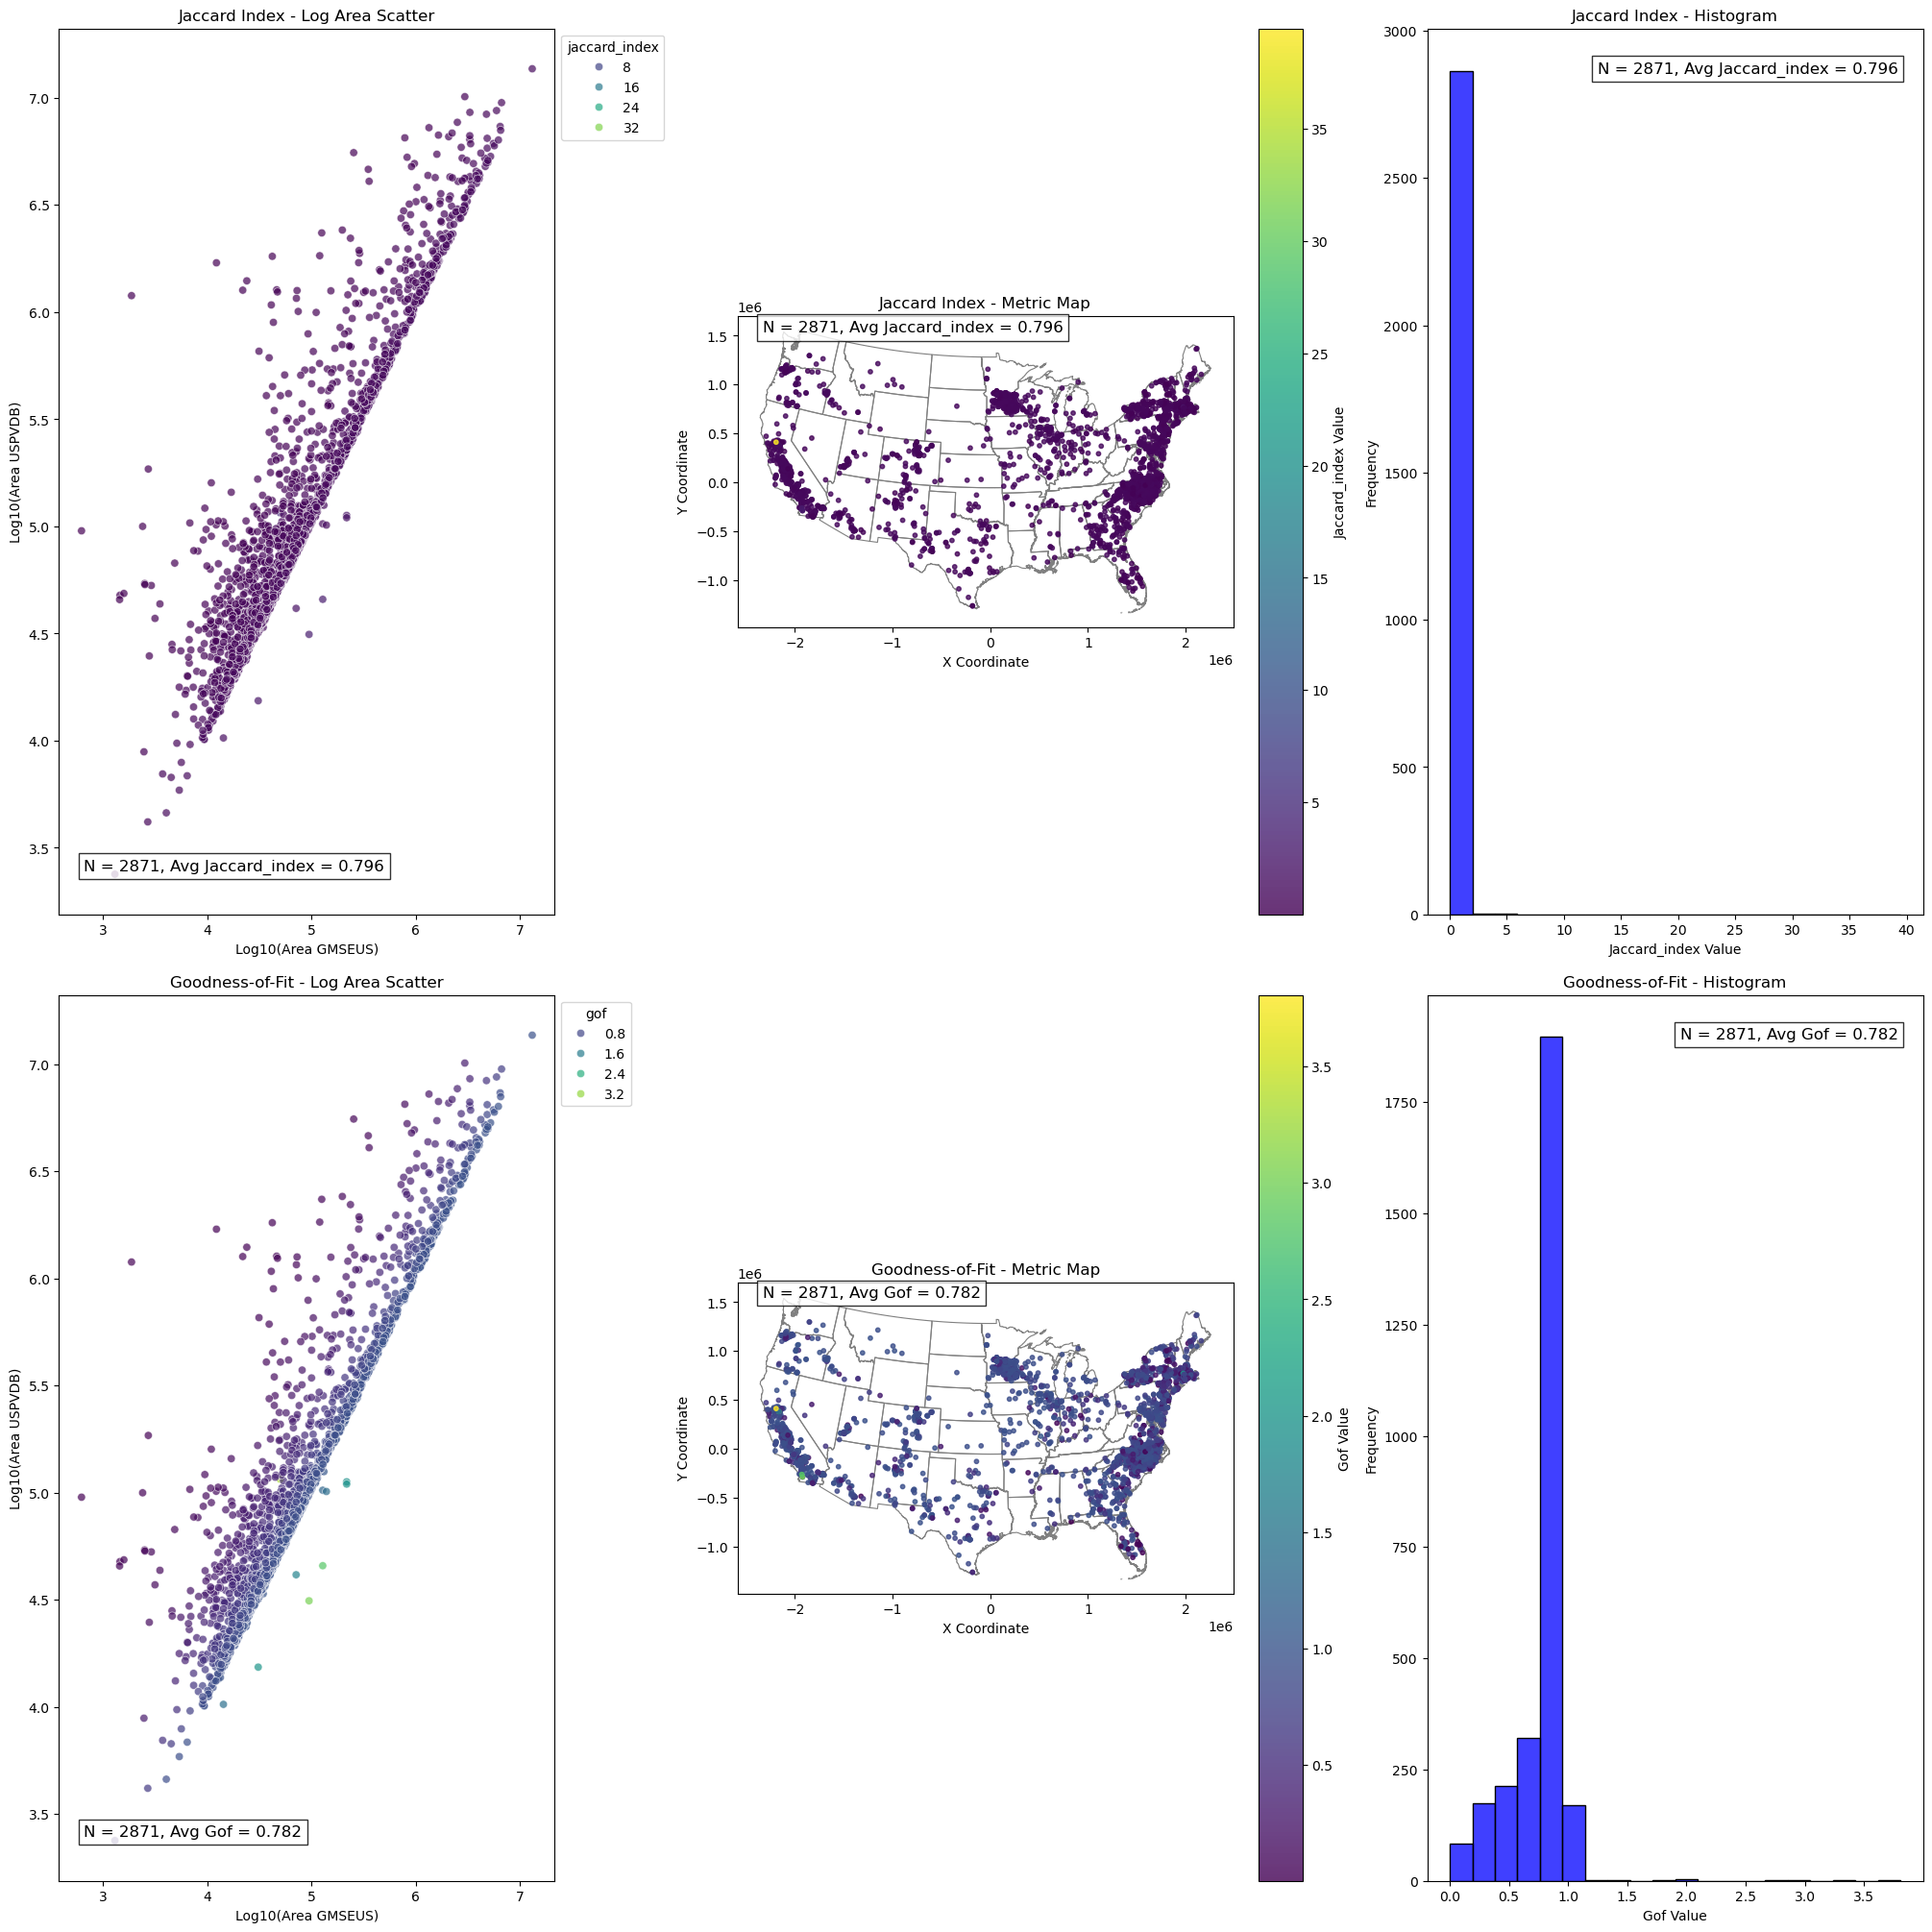

In [59]:
def plot_metric_pairs_with_details(intersections_gdf, boundary_data, metrics, titles, average_values, area_threshold=45):
    """
    Create a 2x3 subplot grid where each row represents a pair of plots for a single metric:
    - Left: Log-transformed scatter plot of areas showing the metric.
    - Middle: Spatial map of the metric values.
    - Right: Histogram of the metric values.
    - Includes rounded average values and count of intersections.
    
    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing intersections and metric values.
        boundary_data (GeoDataFrame): GeoDataFrame representing the boundary map.
        metrics (list of str): List of metrics to visualize (e.g., ["jaccard_index", "gof"]).
        titles (list of str): Titles for each metric row, corresponding to the metrics.
        average_values (list of float): Rounded average values for each metric.
        area_threshold (float): Threshold to filter out small areas from the dataset.
    """
    if len(metrics) != len(titles) or len(metrics) != len(average_values):
        raise ValueError("Metrics, titles, and average_values lists must have the same length.")

    # Create a 2x3 grid for subplots
    fig, axes = plt.subplots(len(metrics), 3, figsize=(20, 10 * len(metrics)), constrained_layout=True)
    
    for i, (metric, title, avg_value) in enumerate(zip(metrics, titles, average_values)):
        # Filter intersections based on area threshold
        filtered_gdf = intersections_gdf[(intersections_gdf['area_a'] > area_threshold) & (intersections_gdf['area_b'] > area_threshold)]
        
        # Check if metric exists
        if metric not in filtered_gdf.columns:
            raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")

        # Scatter plot with log-transformed areas
        filtered_gdf['log_area_a'] = np.log10(filtered_gdf['area_a'])
        filtered_gdf['log_area_b'] = np.log10(filtered_gdf['area_b'])
        
        scatter_ax = axes[i, 0]
        sns.scatterplot(
            data=filtered_gdf,
            x="log_area_a",
            y="log_area_b",
            hue=metric,
            palette="viridis",
            alpha=0.7,
            ax=scatter_ax
        )
        scatter_ax.set_title(f"{title} - Log Area Scatter")
        scatter_ax.set_xlabel("Log10(Area GMSEUS)")
        scatter_ax.set_ylabel("Log10(Area USPVDB)")
        scatter_ax.legend(title=metric, bbox_to_anchor=(1, 1), loc='upper left')
        scatter_ax.text(
            0.05, 0.05,
            f"N = {len(filtered_gdf)}, Avg {metric.capitalize()} = {avg_value}",
            transform=scatter_ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        # Map of metric values
        map_ax = axes[i, 1]
        boundary_data.plot(ax=map_ax, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
        filtered_gdf['x'] = filtered_gdf.geometry.centroid.x
        filtered_gdf['y'] = filtered_gdf.geometry.centroid.y
        scatter = map_ax.scatter(
            filtered_gdf['x'],
            filtered_gdf['y'],
            c=filtered_gdf[metric],
            cmap="viridis",
            s=10,
            alpha=0.8
        )
        cbar = plt.colorbar(scatter, ax=map_ax, orientation='vertical')
        cbar.set_label(f"{metric.capitalize()} Value")
        map_ax.set_title(f"{title} - Metric Map")
        map_ax.set_xlabel("X Coordinate")
        map_ax.set_ylabel("Y Coordinate")
        map_ax.grid(False)
        map_ax.text(
            0.05, 0.95,
            f"N = {len(filtered_gdf)}, Avg {metric.capitalize()} = {avg_value}",
            transform=map_ax.transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.8)
        )

        # Histogram of metric values
        hist_ax = axes[i, 2]
        sns.histplot(filtered_gdf[metric], bins=20, kde=False, ax=hist_ax, color="blue")
        hist_ax.set_title(f"{title} - Histogram")
        hist_ax.set_xlabel(f"{metric.capitalize()} Value")
        hist_ax.set_ylabel("Frequency")
        hist_ax.text(
            0.95, 0.95,
            f"N = {len(filtered_gdf)}, Avg {metric.capitalize()} = {avg_value}",
            transform=hist_ax.transAxes,
            fontsize=12,
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.8)
        )
    
    plt.show()

# Example usage
metrics = ["jaccard_index", "gof"]
titles = ["Jaccard Index", "Goodness-of-Fit"]
average_values = [round(average_jaccard, 3), round(overall_gof, 3)]

# # Count unique USPVDB geometries in intersections
# unique_uspvdb_ids = intersections['uspvdb_id'].nunique()
# print(f"Unique USPVDB geometries in intersections: {unique_uspvdb_ids}")

# # Total rows in intersections
# total_intersections = len(intersections)
# print(f"Total intersections: {total_intersections}")

# # Total geometries in updated USPVDB
# total_uspvdb_geometries = len(updated_uspvdb)
# print(f"Total geometries in updated USPVDB: {total_uspvdb_geometries}")

# # Ensure each USPVDB geometry is counted once per GMSEUS
# unique_intersections = intersections[['uspvdb_id', 'gmseus_id']].drop_duplicates()

# # Count total intersections
# total_unique_intersections = len(unique_intersections)
# print(f"Total unique intersections: {total_unique_intersections}")

# multiple_gmseus_per_uspvdb = intersections.groupby('uspvdb_id').size()
# print(f"Number of USPVDB geometries intersecting multiple GMSEUS geometries: {(multiple_gmseus_per_uspvdb > 1).sum()}")

# usp_intersections_summary = intersections.groupby('uspvdb_id')['gmseus_id'].nunique()
# usp_intersections_summary.name = 'num_gmseus_intersections'
# print(usp_intersections_summary.describe())

# # Add intersection area to intersections GeoDataFrame
# intersections['intersection_area'] = intersections.geometry.area

# # For each USPVDB geometry, retain the GMSEUS geometry with the largest intersection area
# largest_intersection = (
#     intersections.sort_values(by='intersection_area', ascending=False)
#     .drop_duplicates(subset='uspvdb_id')
# )

# print(f"Number of unique USPVDB geometries after simplifying: {len(largest_intersection)}")

# gmseus_grouped_unions = (
#     intersections.groupby('uspvdb_id')['geometry']
#     .apply(lambda g: g.unary_union)
#     .reset_index()
# )
# print(f"Number of unioned geometries: {len(gmseus_grouped_unions)}")

# Plot metric pairs with details
plot_metric_pairs_with_details(final_intersections, us_boundary, metrics, titles, average_values)


C:\Users\Jeremy\AppData\Local\Temp\ipykernel_65436\512736185.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Metric", y="Value", data=boxplot_data, palette="viridis")


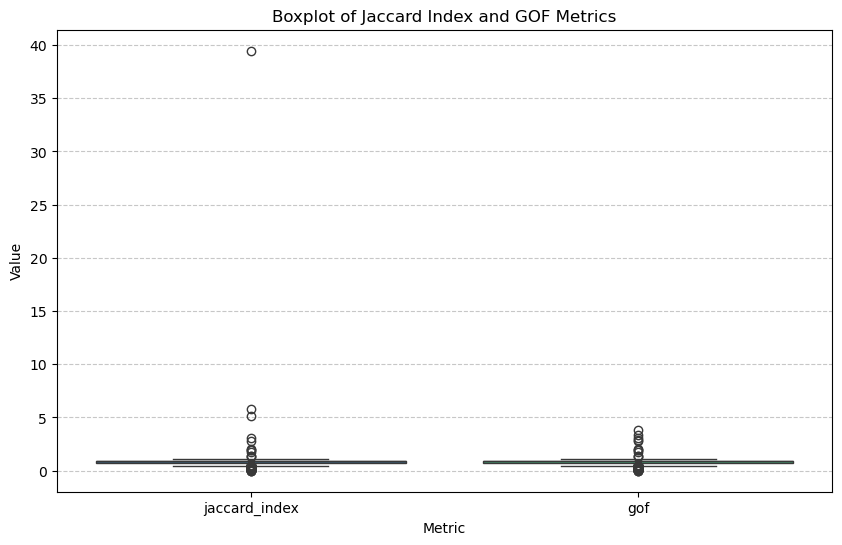

In [60]:
def plot_boxplot_metrics(intersections_gdf, metrics, title="Boxplot of Metrics"):
    """
    Create a boxplot for the given metrics in the GeoDataFrame.

    Parameters:
        intersections_gdf (GeoDataFrame): GeoDataFrame containing the metrics to visualize.
        metrics (list of str): List of metrics to include in the boxplot (e.g., ["jaccard_index", "gof"]).
        title (str): Title for the boxplot.
    """
    # Check if metrics exist in the GeoDataFrame
    for metric in metrics:
        if metric not in intersections_gdf.columns:
            raise ValueError(f"Metric '{metric}' not found in the GeoDataFrame.")
    
    # Prepare data for boxplot
    boxplot_data = intersections_gdf[metrics].melt(var_name="Metric", value_name="Value")
    
    # Create the boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Metric", y="Value", data=boxplot_data, palette="viridis")
    
    # Add title and labels
    plt.title(title)
    plt.xlabel("Metric")
    plt.ylabel("Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.show()

# Example usage
metrics = ["jaccard_index", "gof"]
plot_boxplot_metrics(final_intersections, metrics, title="Boxplot of Jaccard Index and GOF Metrics")

In [62]:
# describe the jaccard index and gof
print(final_intersections['jaccard_index'].describe())
print(final_intersections['gof'].describe())

# plot the maximum jaccard index and gof shape
max_jaccard = final_intersections.loc[final_intersections['jaccard_index'].idxmax()]
max_gof = final_intersections.loc[final_intersections['gof'].idxmax()]

# Plot the GMSEUS geometry with the maximum Jaccard Index
plt.figure(figsize=(10, 6))
max_jaccard['geometry'].boundary.plot(color='red', linewidth=2)
plt.title("GMSEUS Geometry with Maximum Jaccard Index")
plt.axis('off')
plt.show()


count    2871.000000
mean        0.795832
std         0.766778
min         0.001576
25%         0.724200
50%         0.868068
75%         0.913340
max        39.468675
Name: jaccard_index, dtype: float64
count    2871.000000
mean        0.781794
std         0.241843
min         0.001576
25%         0.724200
50%         0.868068
75%         0.913340
max         3.807591
Name: gof, dtype: float64


AttributeError: 'MultiLineString' object has no attribute 'plot'

<Figure size 1000x600 with 0 Axes>

In [55]:
# Generate and export the strange intersections from the new GMSEUS arrays
new_gmseus_arrays = gpd.read_file('G:\\Data\\GMSEUS\\GMSEUS\\GMSEUS_NAIP_Arrays.shp')
new_gmseus_arrays['geometry'] = new_gmseus_arrays.buffer(0)

# load the uspvdb arrays
uspvdb_arrays = gpd.read_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_poly.shp')
uspvdb_arrays['geometry'] = uspvdb_arrays.buffer(0)

# Ensure CRS consistency
if new_gmseus_arrays.crs != uspvdb_arrays.crs:
    uspvdb_arrays = uspvdb_arrays.to_crs(new_gmseus_arrays.crs)

# Add explicit IDs to preserve original indices
new_gmseus_arrays = new_gmseus_arrays.reset_index().rename(columns={'index': 'gmseus_id'})
uspvdb_arrays = uspvdb_arrays.reset_index().rename(columns={'index': 'uspvdb_id'})

# Perform the spatial intersection
intersections = gpd.overlay(new_gmseus_arrays, uspvdb_arrays, how="intersection")

# Group by GMSEUS arrays and count the intersections
gmseus_intersection_counts = intersections.groupby('gmseus_id').size()
gmseus_multiple_indices = gmseus_intersection_counts[gmseus_intersection_counts > 1].index

# Create GeoDataFrame for GMSEUS arrays intersecting multiple times
gmseus_multiple_intersections = new_gmseus_arrays.loc[new_gmseus_arrays['gmseus_id'].isin(gmseus_multiple_indices)]

# Group by USPVDB arrays and count the intersections
uspvdb_intersection_counts = intersections.groupby('uspvdb_id').size()
uspvdb_multiple_indices = uspvdb_intersection_counts[uspvdb_intersection_counts > 1].index

# Create GeoDataFrame for USPVDB arrays being intersected multiple times
uspvdb_multiple_intersections = uspvdb_arrays.loc[uspvdb_arrays['uspvdb_id'].isin(uspvdb_multiple_indices)]

# Export the results as shapefiles
gmseus_multiple_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\gmseus_multiple_intersections.shp')
uspvdb_multiple_intersections.to_file('G:\\Data\\GMSEUS\\intermediateProducts\\uspvdb_multiple_intersections.shp')

print("Shapefiles generated and exported successfully!")

Shapefiles generated and exported successfully!


In [ ]:
from shapely.geometry import box

def trim_map2_to_map1_bounds(map1, map2, buffer_size=50000):
    """
    Trim map2 to the bounding box of map1, expanded by a buffer.
    
    Parameters:
        map1 (GeoDataFrame): First map with reference bounding box.
        map2 (GeoDataFrame): Second map to be trimmed.
        buffer_size (float): Buffer distance to expand the bounding box, in the units of the CRS.
        
    Returns:
        map2_trimmed (GeoDataFrame): Trimmed version of map2.
    """
    # Get the bounding box of map1
    minx, miny, maxx, maxy = map1.total_bounds
    
    # Expand the bounding box by the buffer size
    expanded_bbox = box(minx - buffer_size, miny - buffer_size,
                        maxx + buffer_size, maxy + buffer_size)
    
    # Create a GeoDataFrame for the expanded bounding box
    bbox_gdf = gpd.GeoDataFrame({'geometry': [expanded_bbox]}, crs=map1.crs)
    
    # Clip map2 to the expanded bounding box
    map2_trimmed = gpd.clip(map2, bbox_gdf)
    
    return map2_trimmed

# Apply the trimming
map2_trimmed = trim_map2_to_map1_bounds(map1, map2)

# Verify the results
print(f"Original map2 geometries: {len(map2)}")
print(f"Trimmed map2 geometries: {len(map2_trimmed)}")

# Visualize the trimmed dataset
ax = map1.plot(color='blue', alpha=0.5, edgecolor='black', figsize=(10, 8))
map2_trimmed.plot(ax=ax, color='red', alpha=0.5, edgecolor='black')

In [ ]:
# Plot map 1, labled GMSEUS, include count of rows with a histogram along the top and right showing density
ax = map1.plot(color='blue', alpha=0.5, edgecolor='black', figsize=(10, 8))

In [ ]:
import numpy as np

def plot_map_with_boundary_and_histograms(map_data, map_label, boundary_data):
    """
    Plot a map with histograms for feature density based on x-coordinates (above the map)
    and y-coordinates (to the right of the map). Include a background boundary for reference.
    
    Parameters:
        map_data (GeoDataFrame): GeoDataFrame representing the map to be plotted.
        map_label (str): Label for the map to use in titles and annotations.
        boundary_data (GeoDataFrame): GeoDataFrame representing the background boundary (e.g., lower 48 states).
    """
    # Ensure CRS match between map_data and boundary_data
    if map_data.crs != boundary_data.crs:
        boundary_data = boundary_data.to_crs(map_data.crs)

    # Add x and y coordinates for density calculation (based on centroids)
    map_data['x'] = map_data.geometry.centroid.x
    map_data['y'] = map_data.geometry.centroid.y

    # Clip extreme Y-values for better visualization
    y_min, y_max = np.percentile(map_data['y'], [1, 99])  # Keep the 1st to 99th percentile
    clipped_map_data = map_data[(map_data['y'] >= y_min) & (map_data['y'] <= y_max)]

    # Create a main plot with marginal histograms
    fig = plt.figure(figsize=(14, 12))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

    # Main plot: map visualization
    ax_main = fig.add_subplot(gs[1:, :-1])
    boundary_data.plot(ax=ax_main, color='none', edgecolor='grey', linewidth=0.8, label="Boundary")
    map_data.plot(ax=ax_main, color='blue', alpha=0.5, edgecolor='black', label="Data")
    ax_main.set_title(f"{map_label} with Density Histograms and Boundary")
    ax_main.set_xlabel("X Coordinate")
    ax_main.set_ylabel("Y Coordinate")
    ax_main.legend()

    # Add count of geometries as a label on the map
    geometry_count = len(map_data)
    ax_main.text(
        0.02, 0.98, f"Count of Geometries: {geometry_count}",
        transform=ax_main.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

    # Top histogram: X-coordinate density
    ax_top = fig.add_subplot(gs[0, :-1], sharex=ax_main)
    sns.histplot(map_data['x'], kde=False, color="blue", alpha=0.5, bins=30, ax=ax_top)
    ax_top.set_ylabel("Count")
    ax_top.set_xlabel("")
    ax_top.tick_params(axis="x", labelbottom=False)

    # Right histogram: Y-coordinate density
    ax_right = fig.add_subplot(gs[1:, -1], sharey=ax_main)
    sns.histplot(
        clipped_map_data['y'], kde=False, color="blue", alpha=0.5, bins=30,
        ax=ax_right, orientation="horizontal"
    )
    ax_right.set_xlabel("Count")
    ax_right.set_ylabel("")
    ax_right.tick_params(axis="y", labelleft=False)

    # Adjust limits for better visualization
    max_density = np.histogram(clipped_map_data['y'], bins=30)[0].max()
    ax_right.set_xlim(0, max_density + 10)

    plt.show()

# Example usage:
# Boundary data
us_boundary = gpd.read_file("G:\\Data\\GMSEUS\\SupplementaryData\\CONUS_No_Great_Lakes.shp")
us_boundary = us_boundary.to_crs(map1.crs)

# Plot map1
plot_map_with_boundary_and_histograms(map1, "GMSEUS", us_boundary)

# Plot map2_trimmed
plot_map_with_boundary_and_histograms(map2_trimmed, "USPVDB", us_boundary)